### Libraries

In [1]:
from tools import *
from torch.autograd import Variable, Function
import torch
import math
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
import nibabel as nib
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim.lr_scheduler as schd  
import torchvision.transforms as transforms
%matplotlib inline

### How Much Data is Missing?
The cell below shows a heatmap of missing data from the training samples. Each columns represent a feature. Red means present features whereas blue means absent

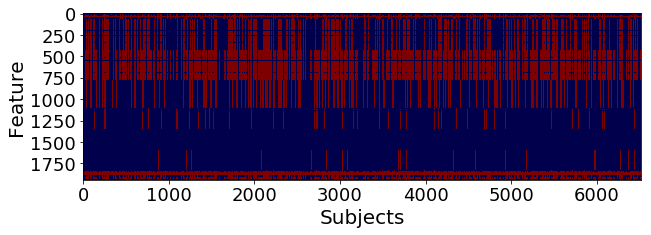

In [3]:
path = "/home/emy24/tadpole/data/"

_, _, _, all_feature, _, _ = preprocess(path,elim_sparse_feature = False)
plt.figure(figsize = (10,10))
plt.imshow(np.transpose((all_feature.iloc[:,:-1].as_matrix() == 1)*1), 
           cmap = "seismic") #Last feature is the IDs, no need to plot
plt.ylabel('Feature', fontsize=20)
plt.xlabel('Subjects', fontsize=20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [ ]:
_, _, _, cutoff20, _, _ = preprocess(path,elim_sparse_feature = True, cutoff = 0.2)
plt.figure(figsize = (10,10))
plt.subplot(1,3,2)
plt.imshow(np.transpose((cutoff20.iloc[:,:-1].as_matrix() == 1)*1),
           cmap = "seismic")
plt.ylabel('Features', fontsize=20)
plt.xlabel('Subjects', fontsize=20)
plt.axis("off")
plt.show()

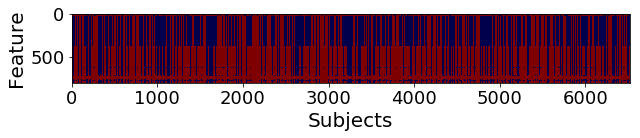

In [5]:
_, _, _, cutoff30, _, _ = preprocess(path,elim_sparse_feature = True, cutoff = 0.3)
plt.figure(figsize = (10,10))
plt.imshow(np.transpose((cutoff30.iloc[:,:-1].as_matrix() == 1)*1), 
           cmap = "seismic")
plt.ylabel('Feature',  fontsize=20)
plt.xlabel('Subjects', fontsize=20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

### Patient Visit Interval

On training data, we want to see what is the month interval at which patients return for visit. 

In [ ]:
path = "/home/emy24/tadpole/data/"
raw_data = pd.read_csv(path + "/TADPOLE_InputData.csv", low_memory=False)
raw_data = raw_data.rename(columns = {'DX':'DX2'}) # Rename that column so there is no conflict in the algorithm

"""Obtain the IDs used for validation and test set"""
val_id = pd.read_csv(path + "/TADPOLE_TargetData_test.csv", low_memory=False)
test_id = pd.read_csv(path + "/TADPOLE_PredictTargetData_valid.csv", low_memory=False)

val_id = val_id["PTID_Key"].unique().astype("int")
test_id = test_id["PTID_Key"].unique().astype("int")

"""Columns 1888,1889, 1890 are numbers. Some number have inequality and some are wrongly typed as string
 The following lines convert everything to float and replace inqualities with NaN"""
raw_data.iloc[:,1888] = pd.to_numeric(raw_data.iloc[:,1888],errors = "coerce")
raw_data.iloc[:,1889] = pd.to_numeric(raw_data.iloc[:,1889],errors = "coerce")
raw_data.iloc[:,1890] = pd.to_numeric(raw_data.iloc[:,1890],errors = "coerce")
raw_data.iloc[:,3] = raw_data.iloc[:,3].astype('category')
raw_data.iloc[:,6] = raw_data.iloc[:,6].astype('category')
raw_data.iloc[:,10] = raw_data.iloc[:,10].astype('category')

""" Column 1891 is mixture of string and number. Get rid of the string """
raw_data.iloc[:,1891] = raw_data.iloc[:,1891].str.extract('(\d+)', expand = False)
raw_data.iloc[:,1891] = pd.to_numeric(raw_data.iloc[:,1891])

"""Remove Columns that does not need one-hot ecoding"""
n_row = raw_data.shape[0]
n_col = raw_data.shape[1]
removed_col = [] 
for n in range(n_col):
    if ("PTID_Key" in raw_data.columns[n] or
        "EXAMDATE" in raw_data.columns[n] or 
        "VERSION" in raw_data.columns[n] or 
        "update" in raw_data.columns[n] or 
        "RUNDATE" in raw_data.columns[n] or 
        "STATUS" in raw_data.columns[n] or 
        "BATCH_UPENNBIOMK9_04_19_17" in raw_data.columns[n] or 
        "KIT_UPENNBIOMK9_04_19_17" in raw_data.columns[n] or 
        "STDS_UPENNBIOMK9_04_19_17" in raw_data.columns[n]) :
        removed_col += [n]    

n = np.arange(n_col)
n = np.setxor1d(removed_col,n)
data = raw_data.iloc[:,n]

"""Search for categorical column and store where NaN are located"""
categorical_col = []
for c in range(data.shape[1]):
    if ((str(data.iloc[:,c].dtype)) == str("category") or 
        data.iloc[:,c].dtype is np.dtype('O')):
        categorical_col += [data.columns[c]]

"""One-hot encode"""
_nan_categories = data.isnull()
data = pd.get_dummies(data)

# Put NaN for the categorical data
for name in categorical_col:
    data.loc[_nan_categories[name], data.columns.str.startswith(name)] = np.NaN

"""Find the Location of NaN. It will be used for the indicator function"""
indicators = pd.isnull(data)
# 1 for existing data and 0 to nan
indicators = (indicators*1==0)*1

"""Reattach removed columns at the end"""
data = pd.concat([data, raw_data.iloc[:,removed_col]], axis=1)
indicators = pd.concat([indicators, raw_data["PTID_Key"]], axis=1) 
#Only ID is needed for the indicators

"""Replace -4 with NaN"""
data = data.replace(-4, np.NaN)
#Make it look pretty :) 
data = data.replace(np.nan,np.NaN)
data = data.replace(np.NAN,np.NaN)

"""Separate Train, Val, Test"""
groups = [data for _, data in data.groupby("PTID_Key")]
indicators_group = [indicators for _, indicators in indicators.groupby("PTID_Key")]

trn_indicator = []
val_indicator = []
test_indicator = []
xTrain = []
xVal = []
xTest = []
for n in range(len(groups)):
    subject = groups[n]["PTID_Key"].unique()[0].astype("int")
    if np.any(val_id == subject):
        groups[n]["EXAMDATE"] = pd.to_datetime(groups[n]["EXAMDATE"])
        groups[n] = groups[n].sort_values("EXAMDATE")
        xVal += [groups[n]]
        val_indicator += [indicators_group[n]]
    elif np.any(test_id == subject):
        groups[n]["EXAMDATE"] = pd.to_datetime(groups[n]["EXAMDATE"])
        groups[n] = groups[n].sort_values("EXAMDATE")
        xTest += [groups[n]]
        test_indicator += [indicators_group[n]]
    else:
        groups[n]["EXAMDATE"] = pd.to_datetime(groups[n]["EXAMDATE"])
        groups[n] = groups[n].sort_values("EXAMDATE")
        xTrain += [groups[n]]
        trn_indicator += [indicators_group[n]]

xTrain = pd.concat(xTrain).reset_index(drop=True)
xTrain["EXAMDATE"] = pd.to_datetime(xTrain["EXAMDATE"])
group = [xTrain for _, xTrain in xTrain.groupby("PTID_Key")] #Group the same patient into a list

diff = np.array([0])
for n in range(len(group)):
#     group[n] = group[n].sort_values("EXAMDATE")
    conseq_diff = group[n]["EXAMDATE"].diff()
    conseq_diff = conseq_diff/ np.timedelta64(1,'M')  #Convert to months
    conseq_diff = conseq_diff.replace(np.NaN,0)
    conseq_diff = conseq_diff.values[1:] #First Value is always 0, eliminate it 
    diff = np.concatenate((diff,conseq_diff))
diff = diff[1:]

plt.hist(diff)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Months Between Visits", fontsize=20)
plt.ylabel("Frequency", fontsize=20)

In [ ]:
path = "/home/emy24/tadpole/data/"

raw_data = pd.read_csv(path + "TADPOLE_TargetData_train.csv", low_memory=False)
raw_data["Date"] = pd.to_datetime(raw_data["Date"])
data = raw_data.dropna(thresh=3)  #you have to have thres data point, if not delete. 
#Thres is 3 because you want Date,PTID_key and an extra variable to be present. 

group = [data for _, data in data.groupby("PTID_Key")] #Group the same patient into a list

diff = np.array([0])
for n in range(len(group)):
    group[n] = group[n].sort_values("Date")
    conseq_diff = group[n]["Date"].diff()
    conseq_diff = conseq_diff/ np.timedelta64(1,'M')  #Convert to months
    conseq_diff = conseq_diff.replace(np.NaN,0)
    conseq_diff = conseq_diff.values[1:] #First Value is always 0, eliminate it 
    diff = np.concatenate((diff,conseq_diff))
diff = diff[1:]

plt.hist(diff)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Months Between Visits", fontsize=20)
plt.ylabel("Frequency",fontsize=20)